In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
import gc

import tensorflow as tf
from keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!curl -L https://anaconda.org/conda-forge/gudhi/3.1.1/download/linux-64/gudhi-3.1.1-py36hd3ef239_1.tar.bz2 | tar xj
!mv lib/python3.6/site-packages/* /usr/local/lib/python3.6/dist-packages/
import gudhi

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3733    0  3733    0     0   7220      0 --:--:-- --:--:-- --:--:--  7206
100 3217k  100 3217k    0     0  1866k      0  0:00:01  0:00:01 --:--:-- 4923k


# Load Dataset

In [ ]:
!pip install kaggle
api_token = {"username":"ignasisanchez","key":"79ae11ad5532231e882297d5df83de82"}
import json
import zipfile
import os
!mkdir /root/.kaggle
!echo '{"username":"ignasisanchez","key":"79ae11ad5532231e882297d5df83de82"}' > /root/.kaggle/kaggle.json
!chmod 600 /content/.kaggle/kaggle.json
!kaggle config path -p /content
!kaggle datasets download -d shayanfazeli/heartbeat
!unzip heartbeat.zip

chmod: cannot access '/content/.kaggle/kaggle.json': No such file or directory
usage: kaggle config [-h] {view,set,unset} ...
kaggle config: error: argument command: invalid choice: 'path' (choose from 'view', 'set', 'unset')
 82% 81.0M/98.8M [00:01<00:00, 45.9MB/s]
100% 98.8M/98.8M [00:01<00:00, 78.7MB/s]
Archive:  heartbeat.zip
  inflating: mitbih_test.csv         
  inflating: mitbih_train.csv        
  inflating: ptbdb_abnormal.csv      
  inflating: ptbdb_normal.csv        


In [ ]:
data=pd.read_csv('mitbih_train.csv', header=None)

X = data[data.columns.values[:-1]]
y = data[data.columns.values[-1]]

# Functions

It is important to execute these cells to be able to execute the code that follows. These functions are for computing the different data representations that will be fed to the networks. The scheduler that will be used for the networks is also coded here.

In [ ]:
def getPersistence(vec, num_points=100, clean=True):
  """
  This transforms the 1D time series vec into a persistence diagram.
  """
  simplex_up = gudhi.SimplexTree()
  simplex_dw = gudhi.SimplexTree()
  # Fullfill the simplexes
  for i in np.arange(len(vec)): 
    simplex_up.insert([i], filtration=vec[i])
    simplex_dw.insert([i], filtration=-vec[i])
  for i in np.arange(len(vec)-1): 
    simplex_up.insert([i, i+1], filtration=vec[i])
    simplex_dw.insert([i, i+1], filtration=-vec[i])
  # Initialize the filtrations
  simplex_up.initialize_filtration()
  simplex_dw.initialize_filtration()


  dig_up = simplex_up.persistence()
  dig_dw = simplex_dw.persistence()

  if clean:
    dig_up = np.asarray([[ele[1][0], ele[1][1]] for ele in dig_up if ele[1][1] < np.inf])
    dig_dw = np.asarray([[ele[1][0], ele[1][1]] for ele in dig_dw if ele[1][1] < np.inf])

  return dig_up, dig_dw, simplex_up, simplex_dw

In [ ]:
def to_betti(vec, num_points=100):
  """
  This transforms the 1D time series vec into a betti curve with 100 points.
  No down simplex
  """
  dig_up, dig_dw, simplex_up, simplex_dw = getPersistence(vec, num_points, clean=True)

  mnu, mxu = np.min(dig_up), np.max(dig_up)
  #mnd, mxd = np.min(dig_dw), np.max(dig_dw)

  v,w = np.zeros(num_points), np.zeros(num_points)

  def functionize(val, descriptor):
    def dirichlet(x):
      return 1 if (x > descriptor[0]) and (x < descriptor[1]) else 0

    return np.vectorize(dirichlet)(val)

  val_up = np.linspace(mnu, mxu, num=num_points)
  #val_dw = np.linspace(mnd, mxd, num=num_points)

  for ele in dig_up: v += functionize(val_up, ele)
  #for ele in dig_dw: w += functionize(val_dw, ele)

  #return np.hstack([v, w])
  return v

In [ ]:
# http://bertrand.michel.perso.math.cnrs.fr/Enseignements/TDA/Tuto-Part4.html
# http://bertrand.michel.perso.math.cnrs.fr/Enseignements/TDA/persistence_graphical_tools_Bertrand.py
def landscapes_approx(diag_dim,x_min,x_max,nb_steps,nb_landscapes):
  """
  Returns nb_landscapes. Same as gudhi implementation
  """
  landscape = np.zeros((nb_landscapes,nb_steps))
  step = (x_max - x_min) / nb_steps
  #Warning: naive and not the best way to proceed!!!!!
  for i in range(nb_steps):
    x = x_min + i * step
    event_list = []
    for pair in diag_dim:
      b = pair[0]
      d = pair[1]
      if (b <= x) and (x<= d):
        if x >= (d+b)/2. :
          event_list.append((d-x))
        else:
          event_list.append((x-b))
    event_list.sort(reverse=True)
    event_list = np.asarray(event_list)
    for j in range(nb_landscapes):
      if(j<len(event_list)):
        landscape[j,i]=event_list[j]
        
  return landscape

In [ ]:
def scheduler(epoch):
  if epoch == 100:
      K.set_value(model.optimizer.learning_rate, model.optimizer.learning_rate/5)
  elif epoch == 200:
      K.set_value(model.optimizer.learning_rate, model.optimizer.learning_rate/5)
  return K.get_value(model.optimizer.learning_rate)

# Landscape levels

It is important to always execute the cells under this section to be able to use any of the Neural Networks coded before. These cells prepare the data for the following networks. 

## Prepare data

In [ ]:
persistence = [getPersistence(X.iloc[i].to_numpy(), num_points=100, clean=False) for i in tqdm(range(X.shape[0]))]
diag = [x[0] for x in persistence]

nbld =  10# number of Landscapes
resolution = 70 ## CHANGE THIS NUMBER DEPENDING ON THE MEMORY THAT YOU CAN USE
length_max = 1
length_min = 0
ld_dim = 0 # landscape dim

L = [ landscapes_approx([x[1] for x in y[1:]], length_min, length_max, resolution,nbld) for y in tqdm(diag) ]

In [ ]:
y_keras = y.copy()
y_keras = pd.get_dummies(y_keras)
LL = np.array(L)
del L

## Normalize area under landscapes

In [ ]:
import sklearn.metrics
x = np.linspace(0,length_max, num=resolution)

for i in tqdm(range(LL.shape[0])):
  for j in range(LL.shape[1]):
    auc = sklearn.metrics.auc(x, LL[i, j, :])
    if np.abs(auc) > 1e-6:
      LL[i, j, :] = LL[i, j, :] / auc 
    
LL.shape

(87554, 10, 70)

# Alternative CNN architecture with All Landscapes

First experiment: propose a CNN architecture that will be fed all Landscapes as a new representation. A new layer (`GatingLayer`) is introduced: this layer serves the purpose to identify which landscapes are important). 

In [ ]:
class GatingLayer(Layer):
    
    def __init__(self):
        super(GatingLayer,self).__init__()
        
    def build(self, input_shape):
        
        self.W=self.add_weight(name="custom_weight", shape=(1,input_shape[1],1,1),
                               initializer="normal")
        
    def call(self, x):
        
        x = self.W*x 
        # apply a softmax if u want them non-negative and less than one otherwise ignore or change it
        x = tf.reduce_sum(x, axis=1)
                
        return x

In [ ]:
history_train_acc =  []
history_train_loss = []
history_val_acc =  []
history_val_loss = []

for i in range(5):
  X_train, X_test, y_train, y_test = train_test_split(LL, y_keras.to_numpy(), test_size=0.2, stratify=y)

  X_train = X_train[:,:,:,np.newaxis]
  X_test = X_test[:,:,:,np.newaxis]

  X_train.shape
  n_outputs = 5
  batch_size = 64


  model = Sequential()
  model.add(InputLayer(input_shape=(nbld, resolution, 1)))

  model.add(Dropout(0.25))
  model.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(nbld, resolution, 1)))
  model.add(MaxPooling2D(pool_size=(1,2)))


  model.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(1,2)))

  model.add(Dropout(0.25))
  model.add(Conv2D(filters=32, kernel_size=2, activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(1,2)))

  model.add(BatchNormalization())
  #model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
  #model.add(MaxPooling2D(pool_size=2))

  model.add(Dropout(0.20))
  model.add(GatingLayer())
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dense(n_outputs, activation='softmax', name="visualized_layer"))
  model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

  model.summary()
  change_lr = LearningRateScheduler(scheduler)
  history = model.fit(x=X_train, y=y_train, epochs=300, validation_data=(X_test, y_test), callbacks=[change_lr])
  history_train_acc.append(history.history['accuracy'])
  history_train_loss.append(history.history['loss'])
  history_val_acc.append(history.history['val_accuracy'])
  history_val_loss.append(history.history['val_loss'])
  K.clear_session()
  del model, history, change_lr, X_train, X_test, y_train, y_test
  gc.collect()
  

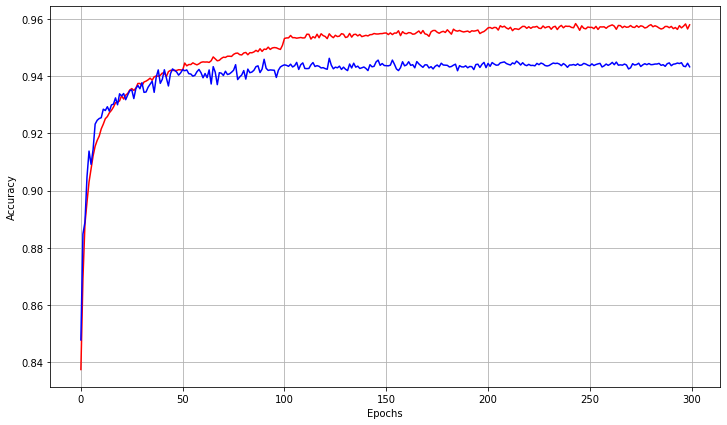

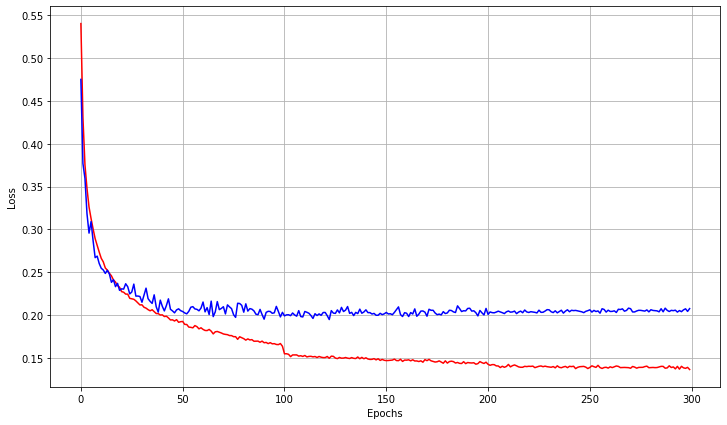

In [ ]:
history_train_acc =  np.array(history_train_acc)
history_train_loss = np.array(history_train_loss)
history_val_acc =  np.array(history_val_acc)
history_val_loss = np.array(history_val_loss)

train_acc_mean = np.mean(history_train_acc, axis=0)
val_acc_mean = np.mean(history_val_acc, axis=0)
train_loss_mean = np.mean(history_train_loss, axis=0)
val_loss_mean = np.mean(history_val_loss, axis=0)

fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(train_acc_mean, color='red')
ax.plot(val_acc_mean, color='blue')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
plt.grid()
plt.show()

fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(train_loss_mean, color='red')
ax.plot(val_loss_mean, color='blue')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.grid()
plt.show()

print("Average accuracy on train: ", train_acc_mean[-1])
print("Average accuracy on validation: ", val_acc_mean[-1])

In [ ]:
model.get_weights()[-5]

array([[[[0.7263808 ]],

        [[0.7094884 ]],

        [[0.5945609 ]],

        [[0.22240159]],

        [[0.13683742]],

        [[0.108706  ]],

        [[0.09710547]],

        [[0.06976306]],

        [[0.03708745]],

        [[0.10332906]]]], dtype=float32)

array([[14353,    19,    76,    18,    55],
       [  217,   217,     7,     0,     6],
       [  179,     1,   922,    16,    37],
       [   30,     0,     5,    82,     4],
       [  118,     0,    45,     1,  1103]])

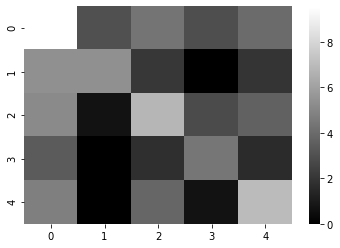

In [ ]:
y_hat = model.predict(X_test)
y_hat_pred = np.array([np.argmax(x) for x in y_hat])
y_test_num = np.array([np.argmax(x) for x in y_test])
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y_test_num, y_hat_pred)
sns.heatmap(np.log(conf+1), cmap='gray')
conf

# Alternative CNN architecture with original data

Second experiment: Run the same CNN architecture but with the original ECG data. There are minor changes to the CNN architecture to adapt it to the new input sizes.

In [ ]:
history_train_acc =  []
history_train_loss = []
history_val_acc =  []
history_val_loss = []

for i in range(5):
  X = data[data.columns.values[:-1]]
  y = data[data.columns.values[-1]]
  y_keras = y.copy()
  y_keras = pd.get_dummies(y_keras)


  X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y_keras.to_numpy(), test_size=0.2)
  X_train = X_train[:,:,np.newaxis]
  X_test = X_test[:,:,np.newaxis]
  print(X_train.shape)
  print(y_train.shape)



  n_timesteps = X.shape[1]
  n_outputs = 5
  batch_size = 64


  model = Sequential()
  model.add(InputLayer(input_shape=(n_timesteps,1)))

  model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(n_timesteps,1)))
  model.add(MaxPooling1D(pool_size=2))

  model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
  model.add(MaxPooling1D(pool_size=2))

  model.add(Conv1D(filters=32, kernel_size=2, activation='relu', padding='same'))
  model.add(MaxPooling1D(pool_size=2))

  #model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
  #model.add(MaxPooling2D(pool_size=2))

  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dense(n_outputs, activation='softmax', name="visualized_layer"))
  model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

  model.summary()
  change_lr = LearningRateScheduler(scheduler)
  history = model.fit(x=X_train, y=y_train, epochs=300, validation_data=(X_test, y_test), callbacks=[change_lr])
  history_train_acc.append(history.history['accuracy'])
  history_train_loss.append(history.history['loss'])
  history_val_acc.append(history.history['val_accuracy'])
  history_val_loss.append(history.history['val_loss'])

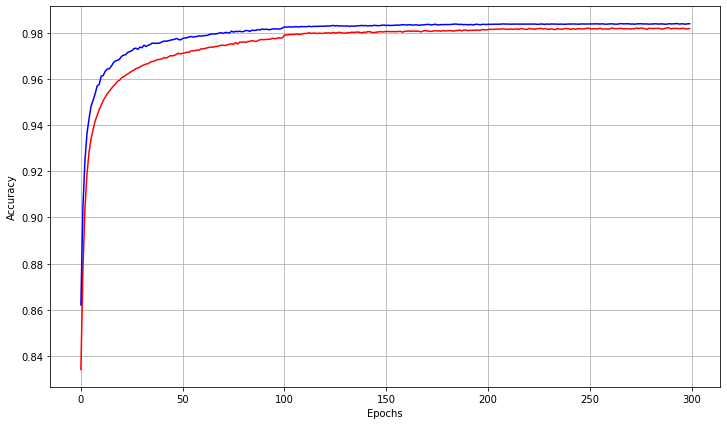

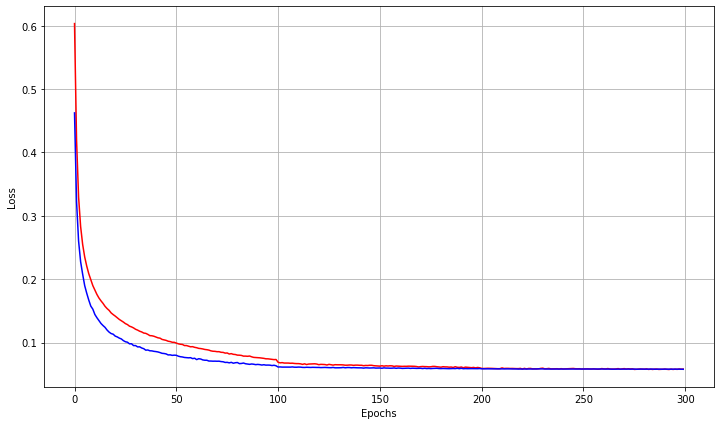

Average accuracy on train:  0.9818654298782349
Average accuracy on validation:  0.9839757919311524


In [ ]:
history_train_acc =  np.array(history_train_acc)
history_train_loss = np.array(history_train_loss)
history_val_acc =  np.array(history_val_acc)
history_val_loss = np.array(history_val_loss)

train_acc_mean = np.mean(history_train_acc, axis=0)
val_acc_mean = np.mean(history_val_acc, axis=0)
train_loss_mean = np.mean(history_train_loss, axis=0)
val_loss_mean = np.mean(history_val_loss, axis=0)

fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(train_acc_mean, color='red')
ax.plot(val_acc_mean, color='blue')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
plt.grid()
plt.show()

fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(train_loss_mean, color='red')
ax.plot(val_loss_mean, color='blue')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.grid()
plt.show()

print("Average accuracy on train: ", train_acc_mean[-1])
print("Average accuracy on validation: ", val_acc_mean[-1])

array([[14443,    16,    15,     8,     7],
       [   95,   337,     5,     0,     2],
       [   38,     1,  1124,     4,     2],
       [   19,     1,    10,   105,     0],
       [   15,     0,     0,     0,  1264]])

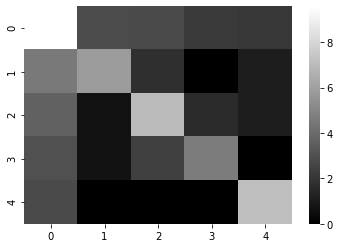

In [ ]:
y_hat = model.predict(X_test)
y_hat_pred = np.array([np.argmax(x) for x in y_hat])
y_test_num = np.array([np.argmax(x) for x in y_test])
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y_test_num, y_hat_pred)
sns.heatmap(np.log(conf+1), cmap='gray')
conf

# Alternative CNN architecture with only 4 landscapes

Third experiment: Let us validate if the landscapes that have been identified as the important ones are really significative and enough for the network to make a classification.

In [ ]:
##You need to execute the cells under Landscape Levels so you have the data into its correct format.
##otherwise it will give an error.
LL = LL[:, :4, :]

history_train_acc =  []
history_train_loss = []
history_val_acc =  []
history_val_loss = []

n_outputs = 5
batch_size = 64

for i in range(5):

  X_train, X_test, y_train, y_test = train_test_split(LL, y_keras.to_numpy(), test_size=0.2, stratify=y)

  X_train = X_train[:,:,:,np.newaxis]
  X_test = X_test[:,:,:,np.newaxis]

  model = Sequential()
  model.add(InputLayer(input_shape=(nbld, resolution, 1)))

  model.add(Dropout(0.25))
  model.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(nbld, resolution, 1)))
  model.add(MaxPooling2D(pool_size=(1,2)))


  model.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(1,2)))

  model.add(Dropout(0.25))
  model.add(Conv2D(filters=32, kernel_size=2, activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(1,2)))

  model.add(BatchNormalization())
  #model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
  #model.add(MaxPooling2D(pool_size=2))

  model.add(Dropout(0.20))
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dense(n_outputs, activation='softmax', name="visualized_layer"))
  model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

  model.summary()
  change_lr = LearningRateScheduler(scheduler)
  history = model.fit(x=X_train, y=y_train, epochs=300, validation_data=(X_test, y_test), callbacks=[change_lr])
  history_train_acc.append(history.history['accuracy'])
  history_train_loss.append(history.history['loss'])
  history_val_acc.append(history.history['val_accuracy'])
  history_val_loss.append(history.history['val_loss'])
  K.clear_session()
  del model, history, change_lr, X_train, X_test, y_train, y_test
  gc.collect()

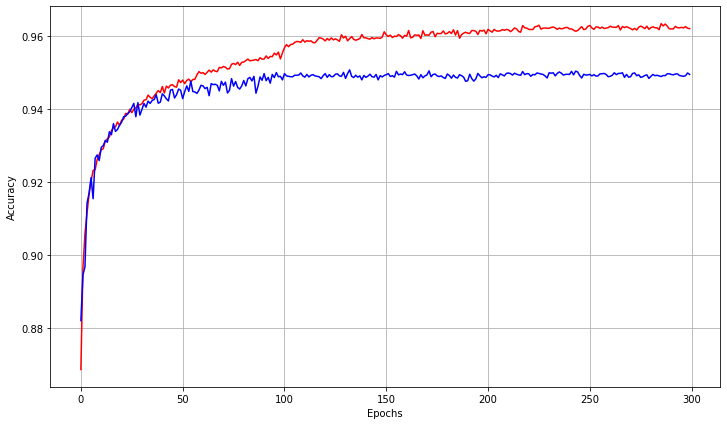

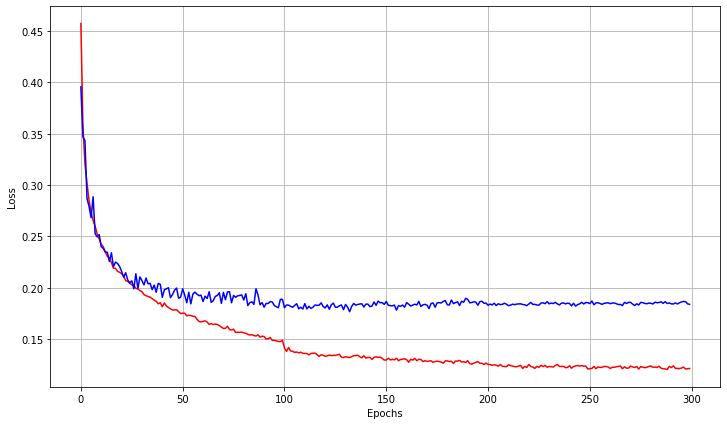

In [ ]:
history_train_acc =  np.array(history_train_acc)
history_train_loss = np.array(history_train_loss)
history_val_acc =  np.array(history_val_acc)
history_val_loss = np.array(history_val_loss)

train_acc_mean = np.mean(history_train_acc, axis=0)
val_acc_mean = np.mean(history_val_acc, axis=0)
train_loss_mean = np.mean(history_train_loss, axis=0)
val_loss_mean = np.mean(history_val_loss, axis=0)

fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(train_acc_mean, color='red')
ax.plot(val_acc_mean, color='blue')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
plt.grid()
plt.show()

fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(train_loss_mean, color='red')
ax.plot(val_loss_mean, color='blue')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.grid()
plt.show()

print("Average accuracy on train: ", train_acc_mean[-1])
print("Average accuracy on validation: ", val_acc_mean[-1])

# Alternative CNN architecture with 4 less significative landscapes

Fourth Experiment: Try to classify using the 4 less significative landscapes to prove that the representation is not trivial.

In [ ]:
##You need to execute the cells under Landscape Levels so you have the data into its correct format.
##otherwise it will give an error.
LL = LL[:, 6:, :]

n_outputs = 5
batch_size = 64

history_train_acc =  []
history_train_loss = []
history_val_acc =  []
history_val_loss = []


for i in range(5):

  X_train, X_test, y_train, y_test = train_test_split(LL, y_keras.to_numpy(), test_size=0.2, stratify=y)

  X_train = X_train[:,:,:,np.newaxis]
  X_test = X_test[:,:,:,np.newaxis]

  model = Sequential()
  model.add(InputLayer(input_shape=(4, resolution, 1)))

  model.add(Dropout(0.25))
  model.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(nbld, resolution, 1)))
  model.add(MaxPooling2D(pool_size=(1,2)))


  model.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(1,2)))

  model.add(Dropout(0.25))
  model.add(Conv2D(filters=32, kernel_size=2, activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(1,2)))

  model.add(BatchNormalization())
  #model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
  #model.add(MaxPooling2D(pool_size=2))

  model.add(Dropout(0.20))
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dense(n_outputs, activation='softmax', name="visualized_layer"))
  model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

  model.summary()
  change_lr = LearningRateScheduler(scheduler)
  history = model.fit(x=X_train, y=y_train, epochs=300, validation_data=(X_test, y_test), callbacks=[change_lr])
  history_train_acc.append(history.history['accuracy'])
  history_train_loss.append(history.history['loss'])
  history_val_acc.append(history.history['val_accuracy'])
  history_val_loss.append(history.history['val_loss'])
  K.clear_session()
  del model, history, change_lr, X_train, X_test, y_train, y_test
  gc.collect()

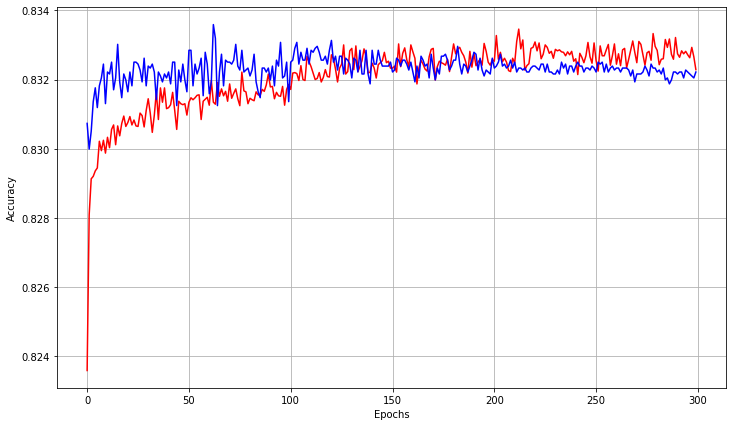

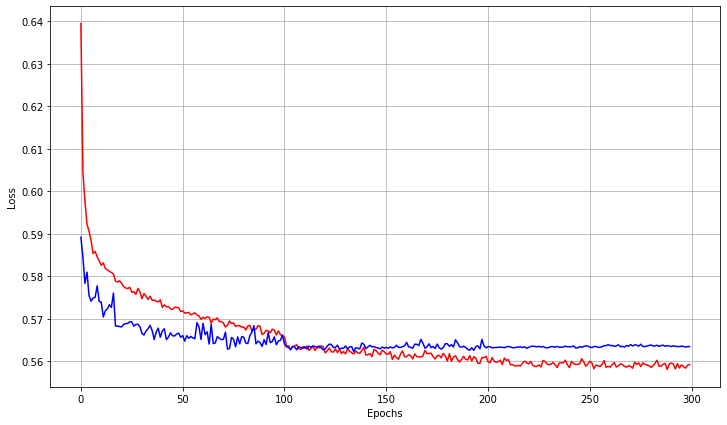

In [ ]:
history_train_acc =  np.array(history_train_acc)
history_train_loss = np.array(history_train_loss)
history_val_acc =  np.array(history_val_acc)
history_val_loss = np.array(history_val_loss)

train_acc_mean = np.mean(history_train_acc, axis=0)
val_acc_mean = np.mean(history_val_acc, axis=0)
train_loss_mean = np.mean(history_train_loss, axis=0)
val_loss_mean = np.mean(history_val_loss, axis=0)

fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(train_acc_mean, color='red')
ax.plot(val_acc_mean, color='blue')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
plt.grid()
plt.show()

fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(train_loss_mean, color='red')
ax.plot(val_loss_mean, color='blue')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.grid()
plt.show()

print("Average accuracy on train: ", train_acc_mean[-1])
print("Average accuracy on validation: ", val_acc_mean[-1])

# Alternative CNN architecture with Betti curves

Fifth experiment: for comparison purposes, run the same CNN architecture but with the betti curves representation.

In [ ]:
embedding_size = 180
betti_curves = np.zeros((X.shape[0], embedding_size))

for i in tqdm(range(X.shape[0])):
    betti_curves[i] = to_betti(X.iloc[i].to_numpy(), num_points=embedding_size)

n_outputs = 5
batch_size = 64

history_train_acc =  []
history_train_loss = []
history_val_acc =  []
history_val_loss = []

for i in range(5):
  X_train, X_test, y_train, y_test = train_test_split(betti_curves, y_keras.to_numpy(), test_size=0.2)
  X_train = X_train[:,:,np.newaxis]
  X_test = X_test[:,:,np.newaxis]

  model = Sequential()
  model.add(InputLayer(input_shape=(embedding_size,1)))

  model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(embedding_size,1)))
  model.add(MaxPooling1D(pool_size=2))

  model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
  model.add(MaxPooling1D(pool_size=2))

  model.add(Conv1D(filters=32, kernel_size=2, activation='relu', padding='same'))
  model.add(MaxPooling1D(pool_size=2))

  #model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
  #model.add(MaxPooling2D(pool_size=2))

  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dense(n_outputs, activation='softmax', name="visualized_layer"))
  model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

  model.summary()
  change_lr = LearningRateScheduler(scheduler)
  history = model.fit(x=X_train, y=y_train, epochs=300, validation_data=(X_test, y_test), callbacks=[change_lr])
  history_train_acc.append(history.history['accuracy'])
  history_train_loss.append(history.history['loss'])
  history_val_acc.append(history.history['val_accuracy'])
  history_val_loss.append(history.history['val_loss'])
  K.clear_session()
  del model, history, change_lr, X_train, X_test, y_train, y_test
  gc.collect()

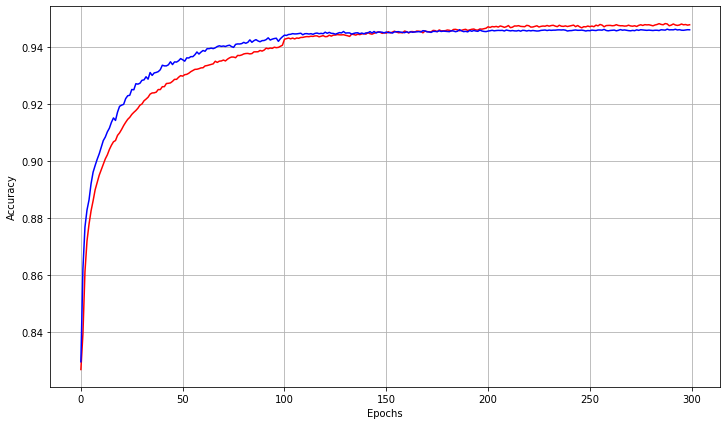

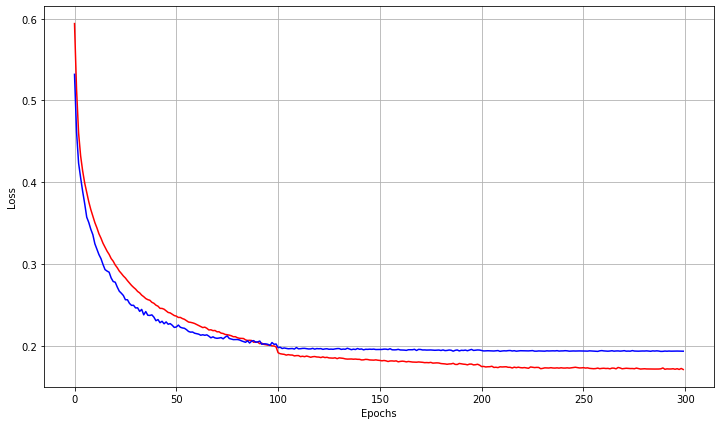

Average accuracy on train:  0.9476864337921143
Average accuracy on validation:  0.9459197044372558


In [ ]:
history_train_acc =  np.array(history_train_acc)
history_train_loss = np.array(history_train_loss)
history_val_acc =  np.array(history_val_acc)
history_val_loss = np.array(history_val_loss)

train_acc_mean = np.mean(history_train_acc, axis=0)
val_acc_mean = np.mean(history_val_acc, axis=0)
train_loss_mean = np.mean(history_train_loss, axis=0)
val_loss_mean = np.mean(history_val_loss, axis=0)

fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(train_acc_mean, color='red')
ax.plot(val_acc_mean, color='blue')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
plt.grid()
plt.show()

fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(train_loss_mean, color='red')
ax.plot(val_loss_mean, color='blue')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.grid()
plt.show()

print("Average accuracy on train: ", train_acc_mean[-1])
print("Average accuracy on validation: ", val_acc_mean[-1])

# Reconstruction of the signal

We propose an approximate reconstructing algorithm.
Once we find which landscapes are significative for the network to make a prediction, we can reconstruct the part of the signal that is producing them. Reconstructing a signal its landscapes is not accurate, as different signals can produce the same landscapes. However, since we can use the original data, we can produce a reconstructing + matching algorithm that can identify the important parts of the signal.

In [ ]:
persistence = [getPersistence(X.iloc[i].to_numpy(), num_points=100, clean=False) for i in tqdm(range(X.shape[0]))]
diag = [x[0] for x in persistence]

nbld =  10# number of Landscapes
#Changing the resolution means that our reconstruction will be a bit more accurate. 
resolution = 70
length_max = 1
length_min = 0
ld_dim = 0 # landscape dim

L = [ landscapes_approx([x[1] for x in y[1:]], length_min, length_max, resolution,nbld) for y in tqdm(diag) ]
LL = np.array(L)
del L
gc.collect()

## Functions for the reconstruction.

In [ ]:
def check_zeros(lst):
  zeros_min = []
  zeros_max = []
  if np.abs(lst[0]) > 10e-6:
    zeros_min.append(0)

  for i in range(1, len(lst)-1):
    if np.abs(lst[i-1]) < 10e-6 and np.abs(lst[i]) > 10e-6 and np.abs(lst[i+1]) > 10e-6:
      zeros_min.append(i)
    elif np.abs(lst[i+1]) < 10e-6 and np.abs(lst[i]) > 10e-6 and np.abs(lst[i-1]) > 10e-6:
      zeros_max.append(i)

  if np.abs(lst[len(lst)-1]) > 10e-6:
    zeros_max.append(len(lst)-1)

  return zeros_min, zeros_max

def check_min_max(lst_min, lst_max, resolution):
  xx = np.linspace(0, 1, resolution)
  min = [xx[i] for i in lst_min]
  max = [xx[i] for i in lst_max]

  return min, max

def get_closest_points(lst_min, lst_max, original):
  x_min = []
  x_max = []
  for m in lst_min:
    x_min.append(np.argmin((original-m)**2))
  for m in lst_max:
    x_max.append(np.argmin((original-m)**2))

  return x_min, x_max

def reconstruct_function_steps(landscapes, original, res, levels=4):
  xx = []
  yy = []
  for i in range(levels):
    lst_min, lst_max = check_zeros(landscapes[i])
    min, max = check_min_max(lst_min, lst_max, res)
    yy = yy + min + max
    x_min, x_max = get_closest_points(min, max, original)
    xx = xx + x_min + x_max

    idx = np.argsort(xx)
    xx = [xx[i] for i in idx]
    yy = [yy[i] for i in idx]

    plt.figure(figsize=(15, 10))
    plt.plot(original)
    plt.plot(xx, yy)
    plt.plot(x_min + x_max, min + max, "*")
    plt.show()
    
  return xx, yy

def reconstruct_function(landscapes, original, res, levels=4):
  xx = []
  yy = []
  for i in range(levels):
    lst_min, lst_max = check_zeros(landscapes[i])
    min, max = check_min_max(lst_min, lst_max, res)
    yy = yy + min + max
    x_min, x_max = get_closest_points(min, max, original)
    xx = xx + x_min + x_max
  
  idx = np.argsort(xx)
  xx = [xx[i] for i in idx]
  yy = [yy[i] for i in idx]
    
  return xx, yy

An example of reconstruction.

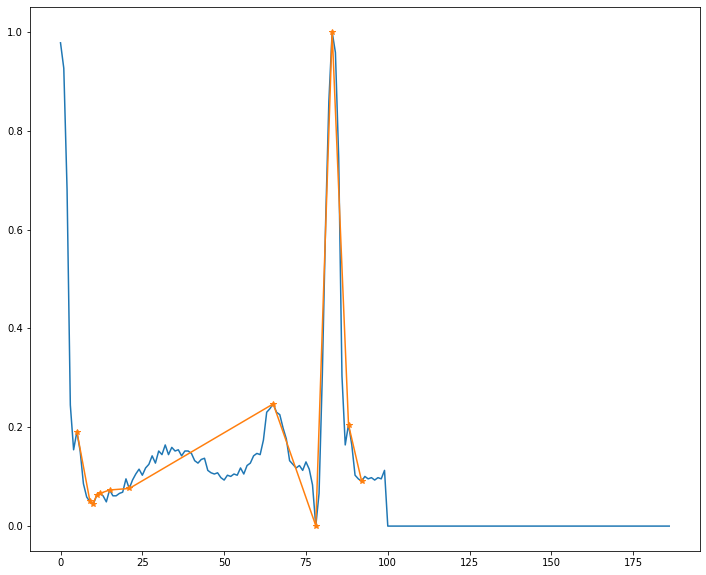

In [ ]:
ii = 0
xx, yy = reconstruct_function(LL[0], X.iloc[ii], resolution, 4)

plt.figure(figsize=(12, 10))
plt.plot(X.iloc[ii])
plt.plot(xx, yy, "*-")
plt.show()